In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow import expand_dims
from tensorflow.keras.losses import MeanAbsolutePercentageError
import tensorflow

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

/home/amirel/.pyenv/versions/3.8.12/envs/time_series/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-09 15:41:26.368408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 15:41:26.770293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-09 15:41:26.797097: W tensorflow/stream_executor/p

# LSTM

In [2]:
df = pd.read_csv('../../AltInt/Inflation_prediction/raw_data/final_df.csv', index_col=0)


In [4]:
df.index = pd.to_datetime(df.index)
df

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,CPI,RPI,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI,RPI YOY
Date,,,,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,84.9,210.1,2.122545,3.757500,300.2,0.142993
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,85.6,211.4,2.129905,3.798333,294.7,0.000000
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,85.8,211.3,2.142045,3.872500,301.1,-0.377181
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,86.0,211.5,2.143250,3.935500,302.9,-1.168224
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,86.4,212.8,2.031900,3.917500,307.2,-1.069270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,120.8,337.1,2.538121,2.240542,538.4,11.659490
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,121.8,340.0,2.933563,2.626558,541.8,11.842105
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,122.5,343.2,2.700779,2.302258,541.0,12.340426


In [5]:
X = df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
y = df['RPI']

In [6]:
X[72:96]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2015-01-01,32.818125,31.737054,1.516177,1.336264,6641.765238,1339.503656,2495.664852,13.099203,0.858274,1.684729,375.9
2015-02-01,38.343255,32.759207,1.533386,1.362371,6746.840476,1356.232800,2536.801725,13.938965,0.952887,1.856450,375.0
2015-03-01,37.866261,31.635113,1.503677,1.377568,6791.140000,1380.431518,2615.694574,13.821672,0.947216,1.783045,377.9
2015-04-01,40.409377,35.572047,1.512909,1.386036,6886.650952,1381.813784,2620.084413,13.690119,0.923663,1.811432,385.1
2015-05-01,42.505052,36.186768,1.543548,1.384014,6864.994500,1360.216539,2568.111738,13.123988,1.009908,1.971630,389.3
2015-06-01,41.067582,35.885473,1.552386,1.385524,6687.803500,1340.919813,2507.691659,13.023503,1.061182,2.089545,389.1
2015-07-01,36.726002,31.989864,1.545617,1.402913,6625.526087,1353.218881,2518.626151,13.169073,1.119989,2.051104,390.2
2015-08-01,31.196110,29.152671,1.545248,1.376957,6402.255000,1311.027051,2434.955959,12.478583,1.085050,1.958367,389.6
2015-09-01,31.774855,30.721787,1.527609,1.364657,6280.524348,1302.101893,2375.712634,12.595702,1.004023,1.908904,390.2


In [7]:
X_train, y_train = X[:72], y[:72]
X_val, y_val = X[72:96], y[72:96]
X_test, y_test = X[96:108], y[96:108]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((72, 11), (72,), (24, 11), (24,), (12, 11), (12,))

In [8]:
y_train_x = expand_dims(y_train, -1)
y_train_x = expand_dims(y_train_x, -1)

y_train_x.shape

2022-09-09 15:42:05.708607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 15:42:05.708759: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 15:42:05.708815: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-S0KUROGM): /proc/driver/nvidia/version does not exist
2022-09-09 15:42:05.709382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([72, 1, 1])

In [9]:
y_val_x = expand_dims(y_val, -1)
y_val_x = expand_dims(y_val_x, -1)

In [10]:
y_val_x.shape

TensorShape([24, 1, 1])

In [11]:
X_test_x = expand_dims(X_test, -2)

In [12]:
X_test_x.shape

TensorShape([12, 1, 11])

In [13]:
X_train_x = expand_dims(X_train, -2)
X_train_x.shape

TensorShape([72, 1, 11])

In [14]:
X_val_x = expand_dims(X_val, -2)
X_val_x.shape

TensorShape([24, 1, 11])

In [25]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [26]:
normalizer = Normalization()
normalizer.adapt(X_train_x)

model1 = Sequential()
model1.add(normalizer)

model1.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model1.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model1.add(Flatten())

model1.add(Dense(100,activation =  'relu'))
model1.add(Dense(50,activation =  'relu'))
model1.add(Dense(25,activation =  'relu'))

model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                      

In [27]:
mape = MeanAbsolutePercentageError()

In [28]:
model1.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [29]:
model1.fit(X_train_x, y_train,batch_size = 32, validation_data=(X_val_x, y_val), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 270ms/step - loss: 99.9965 - mape: 99.9965 - val_loss: 99.9914 - val_mape: 99.9914
Epoch 2/10000
3/3 [==============================] - 0s 18ms/step - loss: 99.9828 - mape: 99.9828 - val_loss: 99.9803 - val_mape: 99.9803
Epoch 3/10000
3/3 [==============================] - 0s 18ms/step - loss: 99.9660 - mape: 99.9660 - val_loss: 99.9664 - val_mape: 99.9664
Epoch 4/10000
3/3 [==============================] - 0s 19ms/step - loss: 99.9438 - mape: 99.9438 - val_loss: 99.9497 - val_mape: 99.9497
Epoch 5/10000
3/3 [==============================] - 0s 17ms/step - loss: 99.9143 - mape: 99.9143 - val_loss: 99.9289 - val_mape: 99.9289
Epoch 6/10000
3/3 [==============================] - 0s 18ms/step - loss: 99.8772 - mape: 99.8772 - val_loss: 99.9013 - val_mape: 99.9013
Epoch 7/10000
3/3 [==============================] - 0s 18ms/step - loss: 99.8232 - mape: 99.8232 - val_loss: 99.8650 - val_mape: 99.8650
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 16ms/step - loss: 6.9138 - mape: 6.9138 - val_loss: 6.3662 - val_mape: 6.3662
Epoch 61/10000
3/3 [==============================] - 0s 16ms/step - loss: 6.6419 - mape: 6.6419 - val_loss: 6.4257 - val_mape: 6.4257
Epoch 62/10000
3/3 [==============================] - 0s 16ms/step - loss: 6.4746 - mape: 6.4746 - val_loss: 6.1788 - val_mape: 6.1788
Epoch 63/10000
3/3 [==============================] - 0s 15ms/step - loss: 6.3480 - mape: 6.3480 - val_loss: 6.4690 - val_mape: 6.4690
Epoch 64/10000
3/3 [==============================] - 0s 16ms/step - loss: 6.1709 - mape: 6.1709 - val_loss: 6.5160 - val_mape: 6.5160
Epoch 65/10000
3/3 [==============================] - 0s 15ms/step - loss: 6.0242 - mape: 6.0242 - val_loss: 6.0979 - val_mape: 6.0979
Epoch 66/10000
3/3 [==============================] - 0s 16ms/step - loss: 5.9136 - mape: 5.9136 - val_loss: 6.3835 - val_mape: 6.3835
Epoch 67/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 17ms/step - loss: 1.3442 - mape: 1.3442 - val_loss: 5.5808 - val_mape: 5.5808
Epoch 121/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2744 - mape: 1.2744 - val_loss: 5.8266 - val_mape: 5.8266
Epoch 122/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.4056 - mape: 1.4056 - val_loss: 5.3140 - val_mape: 5.3140
Epoch 123/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.3416 - mape: 1.3416 - val_loss: 5.1448 - val_mape: 5.1448
Epoch 124/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2727 - mape: 1.2727 - val_loss: 5.3989 - val_mape: 5.3989
Epoch 125/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2583 - mape: 1.2583 - val_loss: 4.8290 - val_mape: 4.8290
Epoch 126/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2798 - mape: 1.2798 - val_loss: 5.1136 - val_mape: 5.1136
Epoch 127/10000
3/3 [==============================] - 0s 18ms/s

3/3 [==============================] - 0s 16ms/step - loss: 0.5286 - mape: 0.5286 - val_loss: 2.5440 - val_mape: 2.5440
Epoch 181/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.5312 - mape: 0.5312 - val_loss: 2.5394 - val_mape: 2.5394
Epoch 182/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.5442 - mape: 0.5442 - val_loss: 2.5301 - val_mape: 2.5301
Epoch 183/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5884 - mape: 0.5884 - val_loss: 2.4854 - val_mape: 2.4854
Epoch 184/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.5015 - mape: 0.5015 - val_loss: 2.5080 - val_mape: 2.5080
Epoch 185/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6015 - mape: 0.6015 - val_loss: 2.5074 - val_mape: 2.5074
Epoch 186/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.6809 - mape: 0.6809 - val_loss: 2.5296 - val_mape: 2.5296
Epoch 187/10000
3/3 [==============================] - 0s 16ms/s

3/3 [==============================] - 0s 15ms/step - loss: 0.3706 - mape: 0.3706 - val_loss: 2.5089 - val_mape: 2.5089
Epoch 241/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.4181 - mape: 0.4181 - val_loss: 2.5009 - val_mape: 2.5009
Epoch 242/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.3953 - mape: 0.3953 - val_loss: 2.4820 - val_mape: 2.4820
Epoch 243/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.3413 - mape: 0.3413 - val_loss: 2.4384 - val_mape: 2.4384
Epoch 244/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.3604 - mape: 0.3604 - val_loss: 2.4575 - val_mape: 2.4575
Epoch 245/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.5594 - mape: 0.5594 - val_loss: 2.3942 - val_mape: 2.3942
Epoch 246/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.4546 - mape: 0.4546 - val_loss: 2.4291 - val_mape: 2.4291
Epoch 247/10000
3/3 [==============================] - 0s 17ms/s

3/3 [==============================] - 0s 16ms/step - loss: 0.4019 - mape: 0.4019 - val_loss: 2.4317 - val_mape: 2.4317
Epoch 301/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5604 - mape: 0.5604 - val_loss: 2.3603 - val_mape: 2.3603
Epoch 302/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.4997 - mape: 0.4997 - val_loss: 2.3299 - val_mape: 2.3299
Epoch 303/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.5151 - mape: 0.5151 - val_loss: 2.3708 - val_mape: 2.3708
Epoch 304/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.3654 - mape: 0.3654 - val_loss: 2.4249 - val_mape: 2.4249
Epoch 305/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.3706 - mape: 0.3706 - val_loss: 2.3219 - val_mape: 2.3219
Epoch 306/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5918 - mape: 0.5918 - val_loss: 2.3348 - val_mape: 2.3348
Epoch 307/10000
3/3 [==============================] - 0s 17ms/s

3/3 [==============================] - 0s 18ms/step - loss: 0.3539 - mape: 0.3539 - val_loss: 2.4311 - val_mape: 2.4311
Epoch 361/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.4359 - mape: 0.4359 - val_loss: 2.3050 - val_mape: 2.3050
Epoch 362/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.4502 - mape: 0.4502 - val_loss: 2.3499 - val_mape: 2.3499


In [30]:
model1.predict(X_test_x)


1/1 [==============================] - 0s 458ms/step


array([[265.6504 ],
       [266.59818],
       [265.92868],
       [267.57196],
       [268.58353],
       [268.35617],
       [268.26636],
       [268.0761 ],
       [268.89023],
       [269.05786],
       [269.9922 ],
       [271.66568]], dtype=float32)

In [31]:
test_predictions = list(model1.predict(X_test_x))
test_results = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results['date'] = list(y_test.index)
test_results['test_predictions'] = [x[0] for x in test_predictions]
test_results['test_actual'] = list(y_test)


1/1 [==============================] - 0s 17ms/step


In [32]:
test_results

,test_predictions,test_actual,date
0,265.650391,265.5,2017-01-01
1,266.598175,268.4,2017-02-01
2,265.928680,269.3,2017-03-01
3,267.571960,270.6,2017-04-01
4,268.583527,271.7,2017-05-01
5,268.356171,272.3,2017-06-01
6,268.266357,272.9,2017-07-01
7,268.076111,274.7,2017-08-01
8,268.890228,275.1,2017-09-01
9,269.057861,275.3,2017-10-01


In [33]:
test_results.set_index('date', inplace=True)

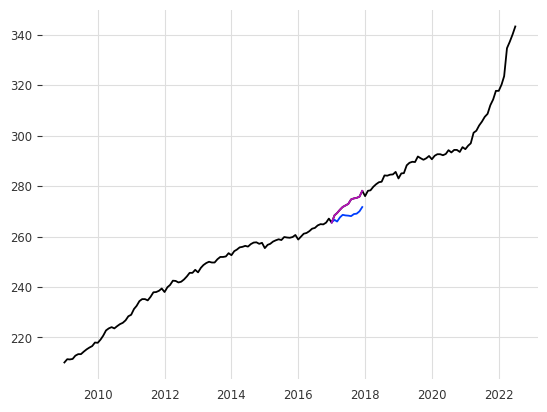

In [44]:
import matplotlib.pyplot as plt

fig1 = plt.plot(y)
fig1 = plt.plot(test_results['test_predictions'], label='prediction')
fig1 = plt.plot(test_results['test_actual'], label='actual')
